In [1]:
#conda activate comp-methods3

In [12]:
#!pip install anndata
#!pip install hdf5plugin
#!pip install anndata2ri
#!pip install rpy2
#!pip install episcanpy

In [1]:
import anndata as ad
import hdf5plugin

# preprocessed data from the episcanpy tutorial
adata = ad.read("Adata.h5ad")

In [8]:
import anndata2ri
import logging
from scipy.sparse import issparse
import episcanpy as epi

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%reload_ext rpy2.ipython

In [4]:
import scipy

data_mat = adata.X.T

# convert to CSC if possible. See https://github.com/MarioniLab/scran/issues/70
if scipy.sparse.issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata.obs["leiden"]

In [5]:
%%R -i data_mat -o size_factors
library(scran)
library(BiocParallel)

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)

In [6]:
from scipy.sparse import csr_matrix, issparse

adata.obs["size_factors"] = size_factors

In [9]:
scran = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = csr_matrix(epi.pp.log1p(scran))

In [25]:
#epi.tl.rank_features(adata, layer="scran_normalization", use_raw = False)

In [11]:
adata

AnnData object with n_obs × n_vars = 3683 × 10000
    obs: 'cell_type', 'n_features', 'log_n_features', 'nucleosome_signal', 'tss_enrichment_score', 'tss', 'passes_filter', 'leiden', 'clusters', 'size_factors'
    var: 'chr', 'start', 'stop', 'n_cells', 'log_n_cells', 'passes_filter', 'prop_shared_cells', 'variability_score', 'highly_variable'
    uns: 'cell_type_colors', 'clusters_colors', 'dendrogram_cell_type', 'fragment_lengths', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_features_groups', 'tss_enrichment', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'scran_normalization'
    obsp: 'connectivities', 'distances'

The essential difference of logistic regression to t-test is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. Clark et al. (2014) has more details.

"The final step in our pipeline analysis is the detection of DE-
genes. Recently, Soneson et al. 31 benchmarked 36 DE approaches
and found that edgeR 27 , MAST35 , limma-trend36 and even the T-
Test performed well.
Both edgeR-zingeR and limma-trend in combination with a
good normalisation reach similar pAUCs as using the simulated
size factors (Fig. 4)"

"Nevertheless, we find that DE-analysis performance strongly
depends on the normalisation method and on the library
preparation method. In combination with the simulated size
factors or scran normalisation, even a T-Test performs well."

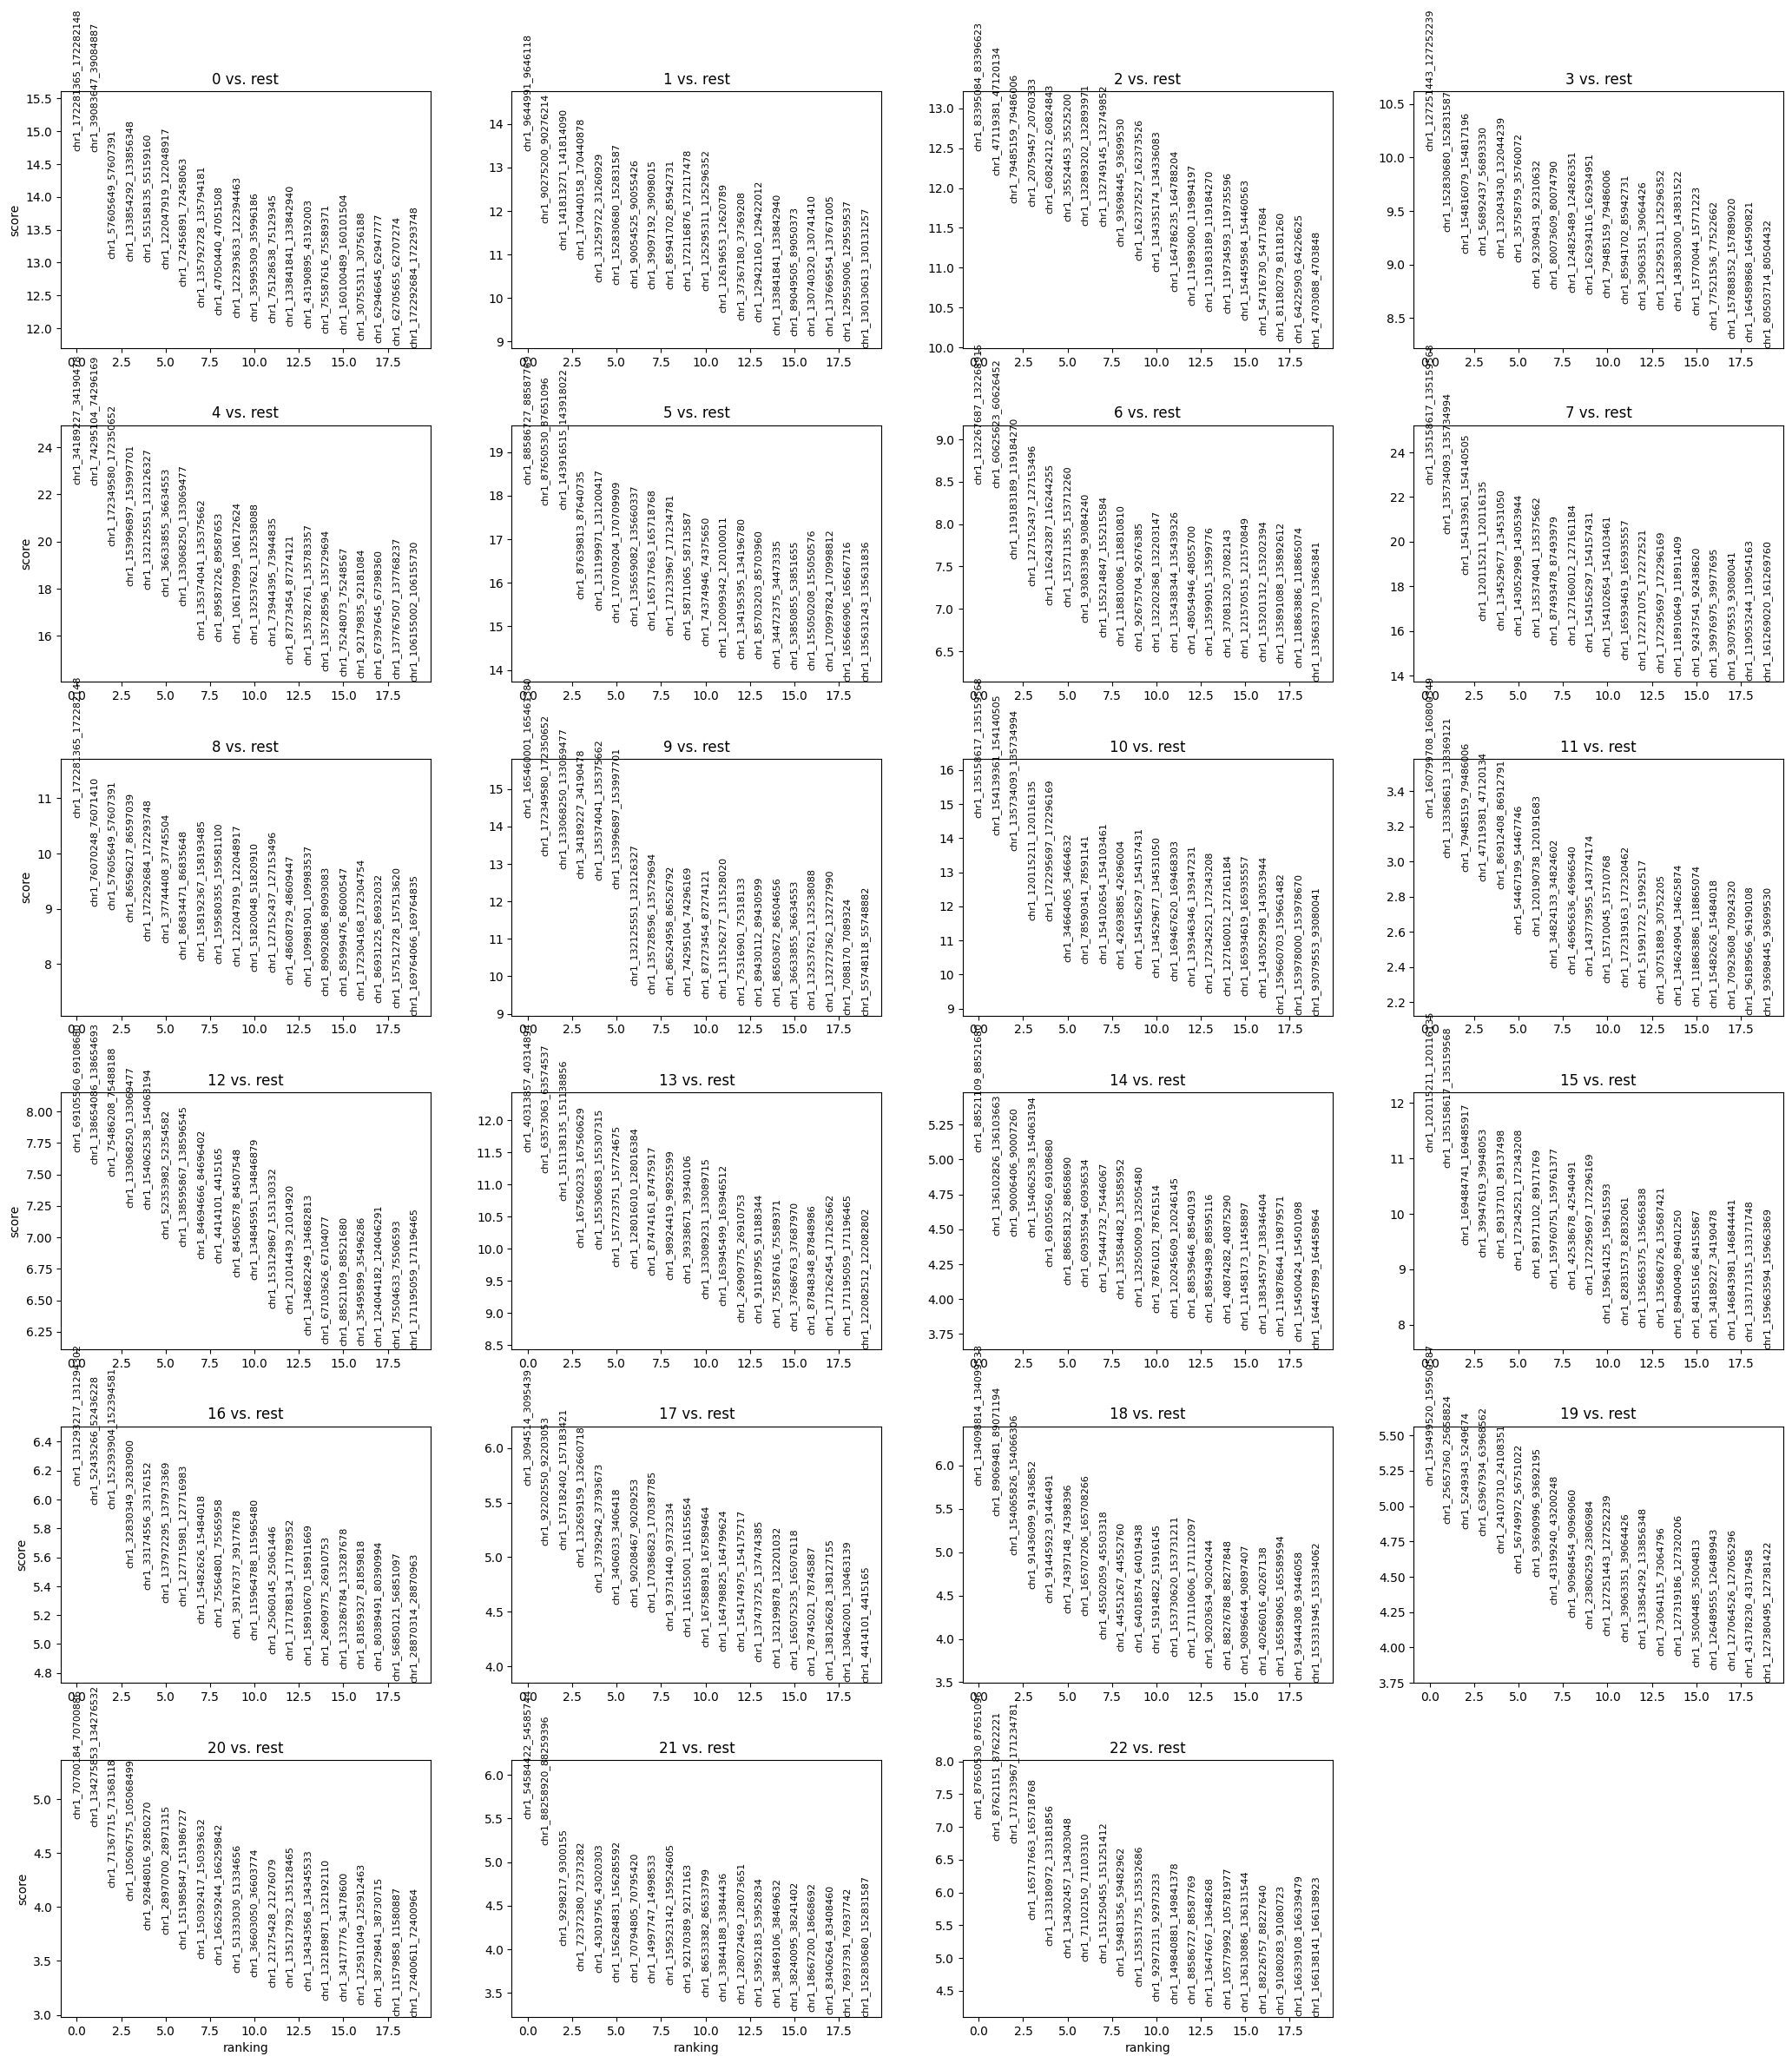

In [46]:
# https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_05_dge.html



import scanpy as sc

adata.uns['log1p']["base"] = None

sc.tl.rank_genes_groups(adata, 'leiden', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(adata, sharey=False, key = "t-test")

In [45]:
adata.obs["leiden"]

AAACGAAAGTAATCAG-1     3
AAACGAACACGCTGTG-1     0
AAACGAATCCTGGGAC-1     3
AAACGAATCGGGAAAC-1     5
AAACTCGAGAAAGCAG-1     0
                      ..
TTTGTGTGTACTTCAG-1    11
TTTGTGTGTCATAAGA-1     0
TTTGTGTTCAGGGTTT-1     1
TTTGTGTTCTCTGCGT-1     6
TTTGTGTTCTTACTCA-1    15
Name: leiden, Length: 3683, dtype: category
Categories (23, object): ['0', '1', '2', '3', ..., '19', '20', '21', '22']

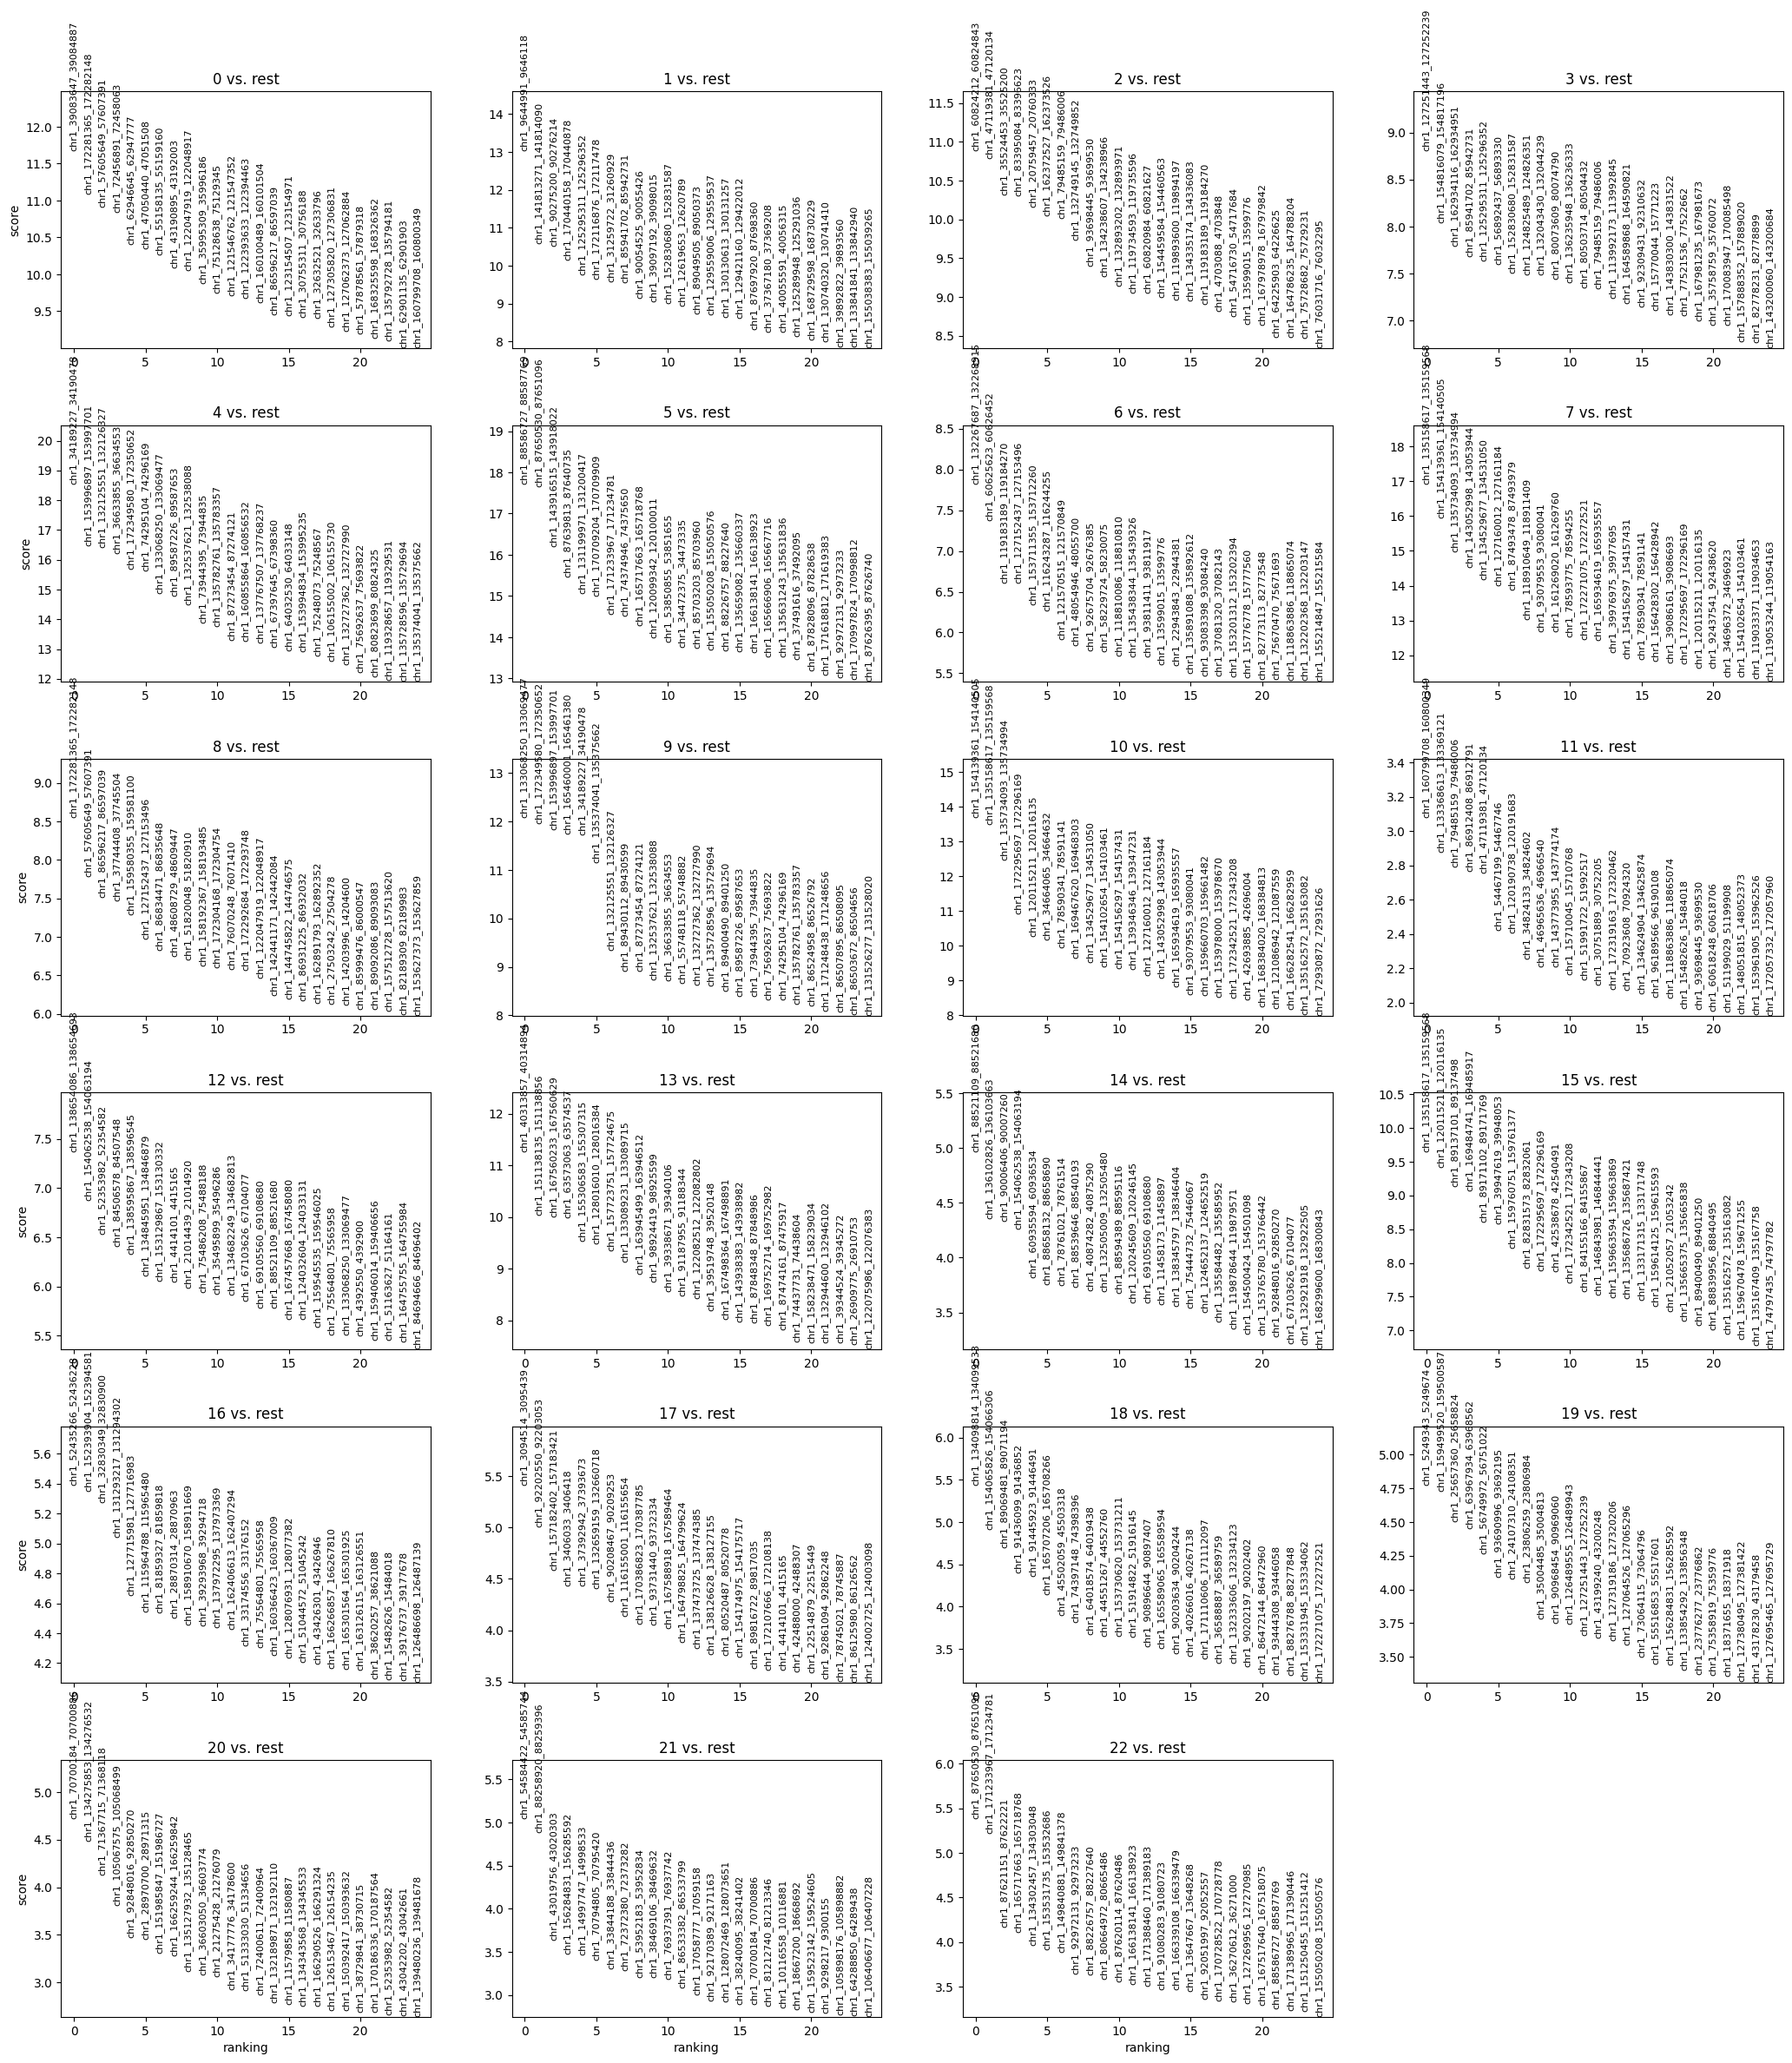

In [34]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test_overestim_var', key_added = "t-test_ov")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test_ov")

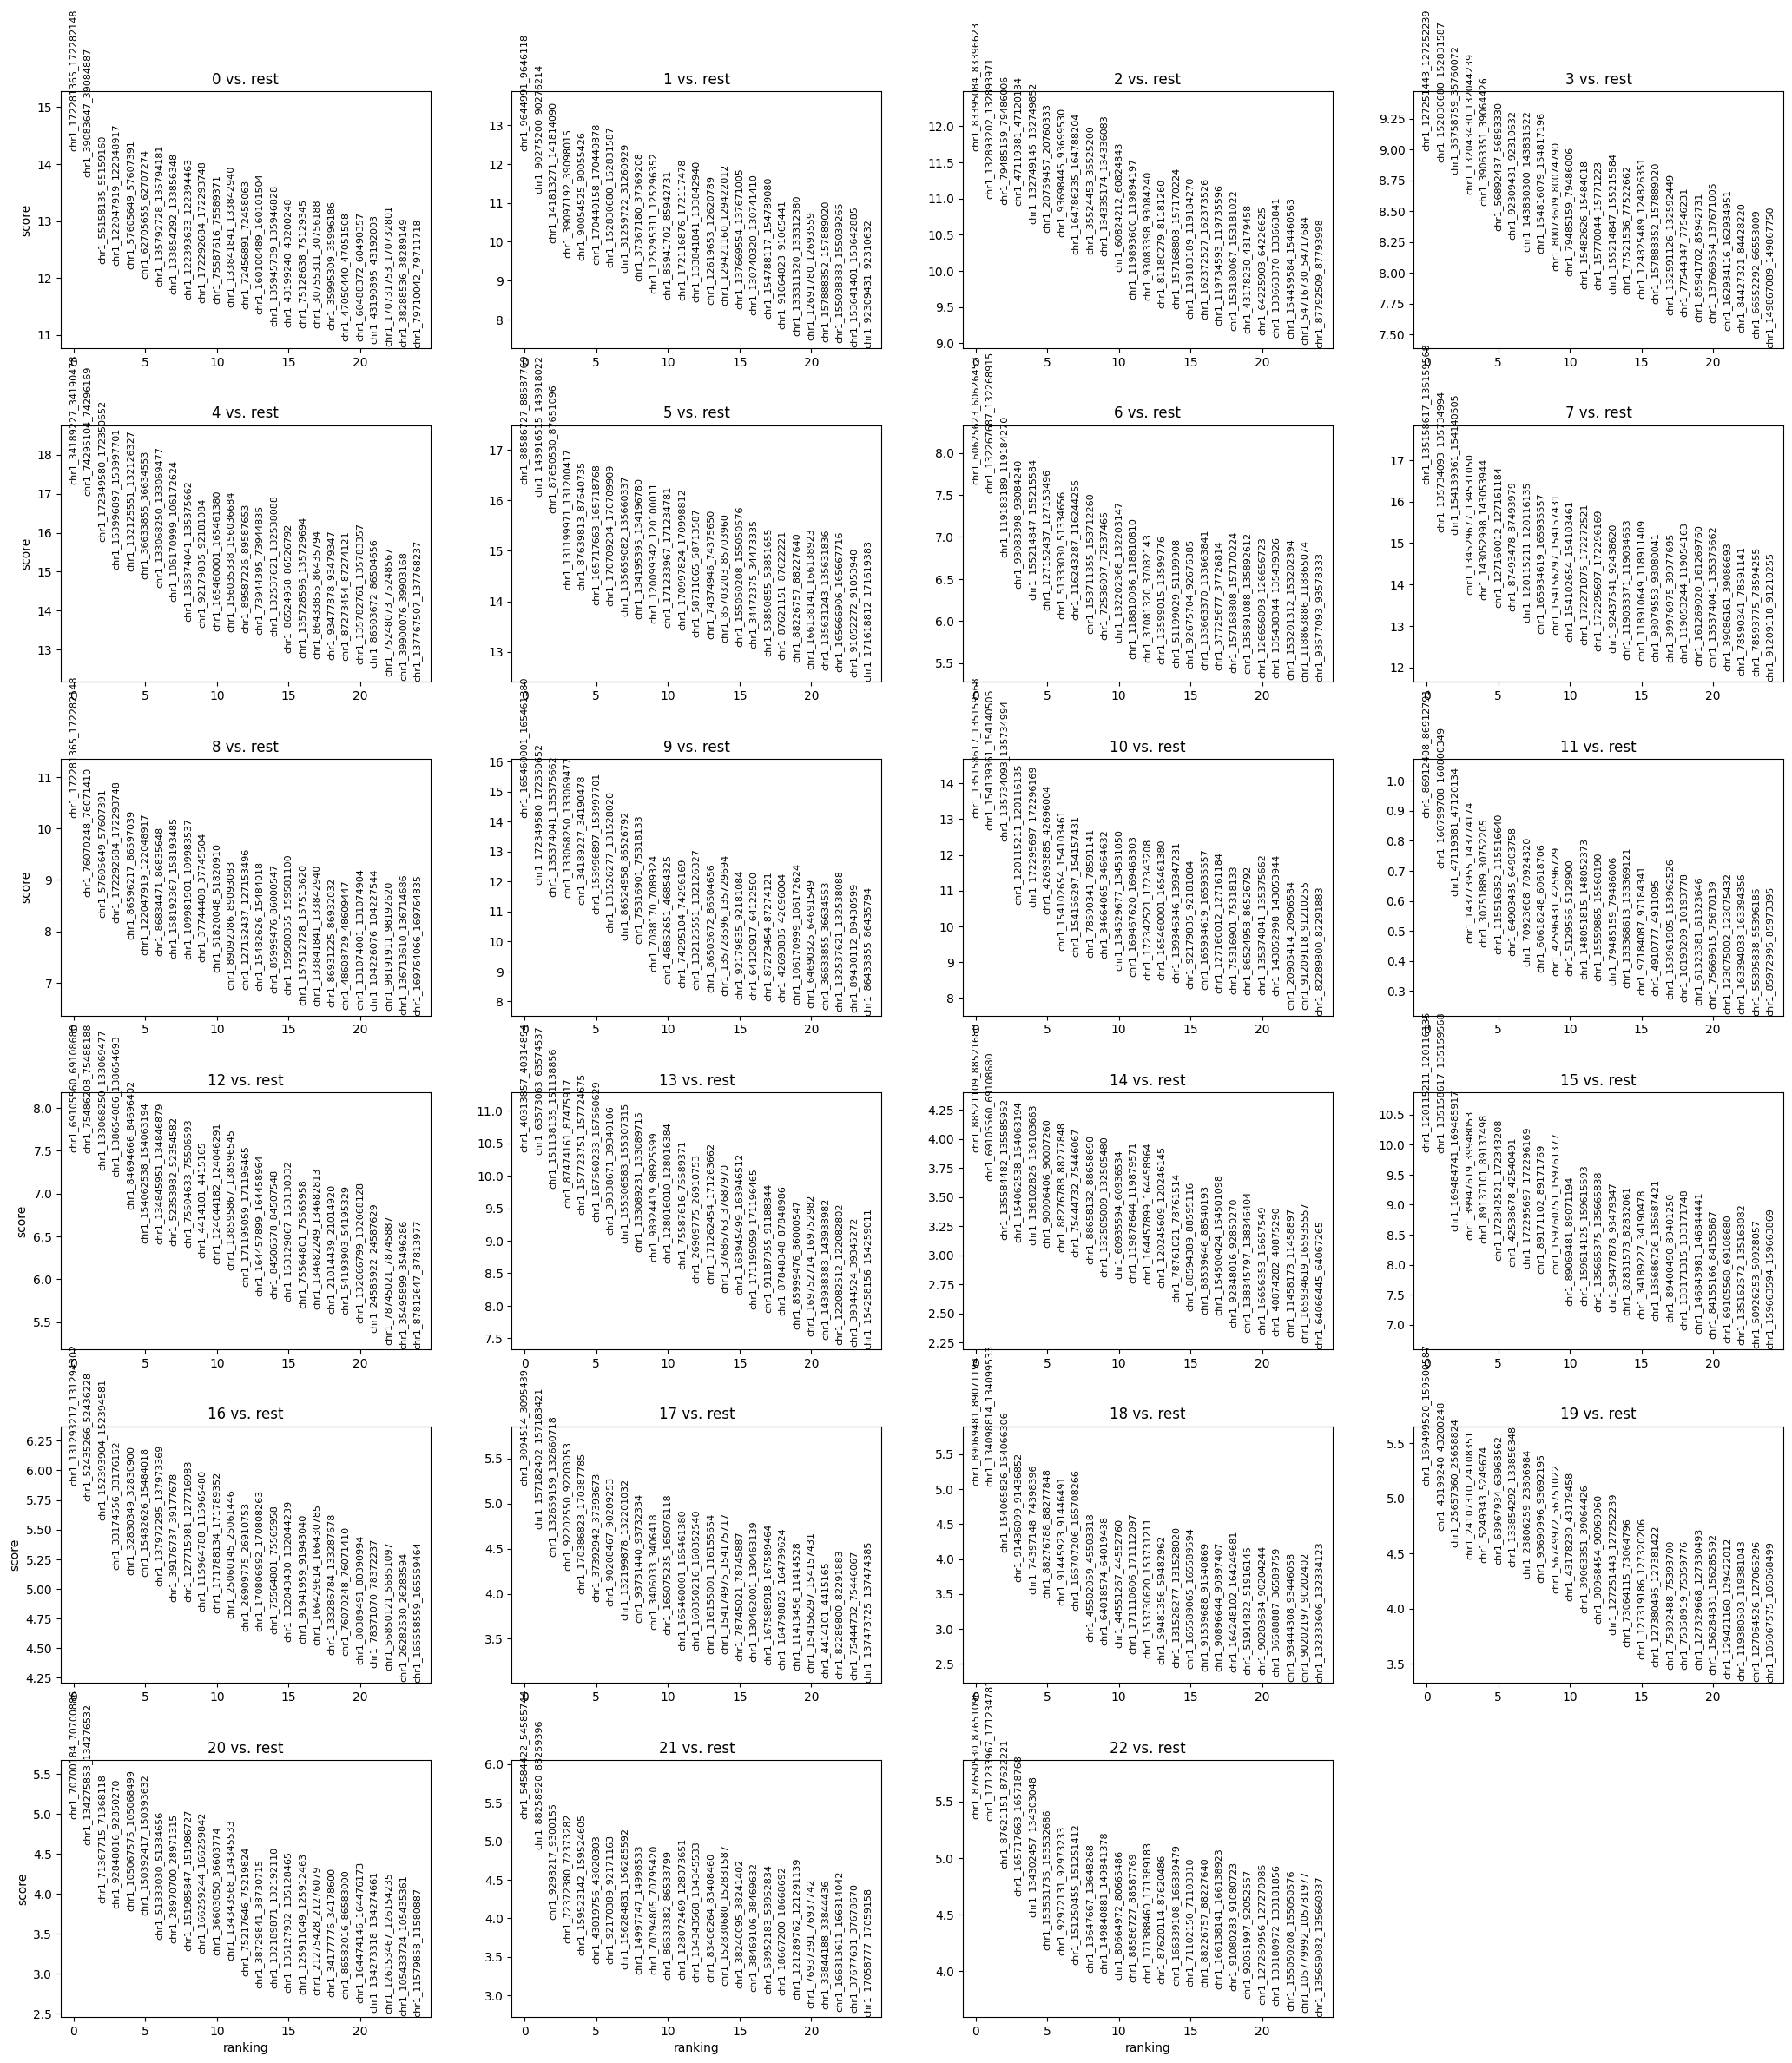

In [35]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


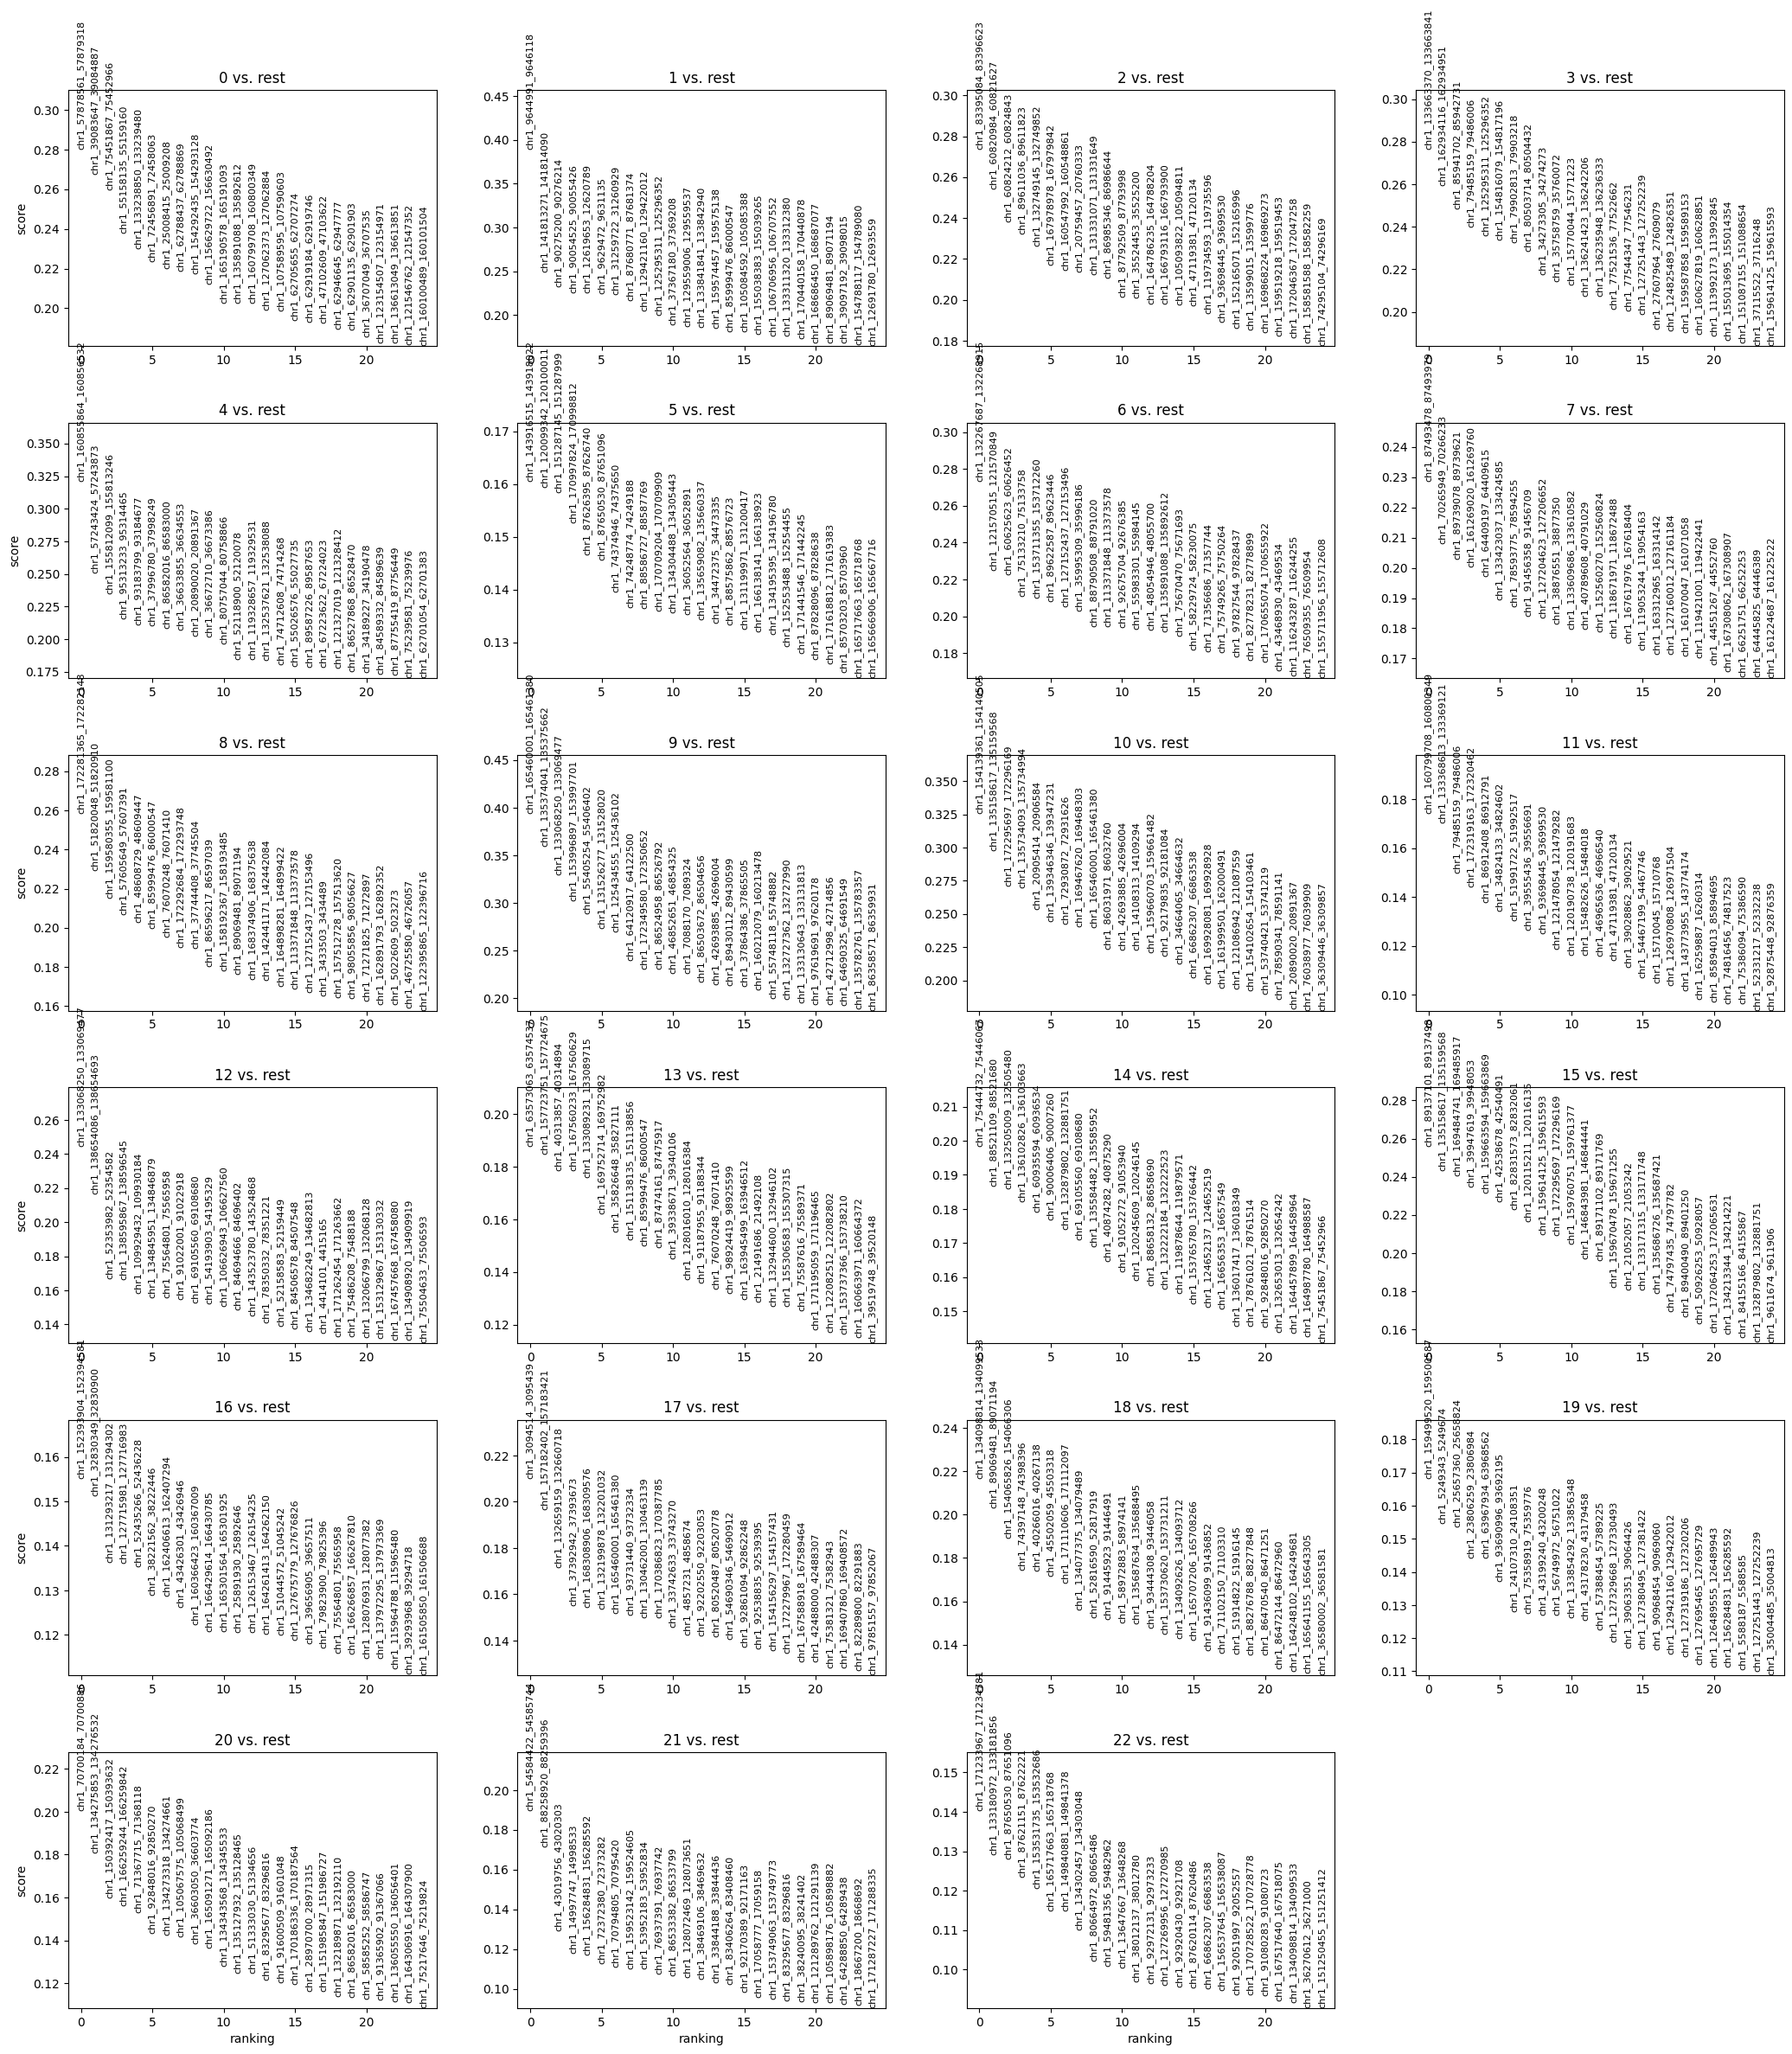

In [36]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg',key_added = "logreg")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "logreg")

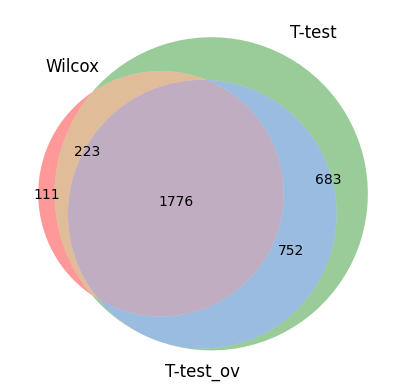

In [40]:
#compare cluster1 genes, only stores top 100 by default

wc = sc.get.rank_genes_groups_df(adata, group='0', key='wilcoxon', pval_cutoff=0.01, log2fc_min=0)['names']
tt = sc.get.rank_genes_groups_df(adata, group='0', key='t-test', pval_cutoff=0.01, log2fc_min=0)['names']
tt_ov = sc.get.rank_genes_groups_df(adata, group='0', key='t-test_ov', pval_cutoff=0.01, log2fc_min=0)['names']

from matplotlib_venn import venn3
import matplotlib.pyplot as plt

venn3([set(wc),set(tt),set(tt_ov)], ('Wilcox','T-test','T-test_ov') )
plt.show()

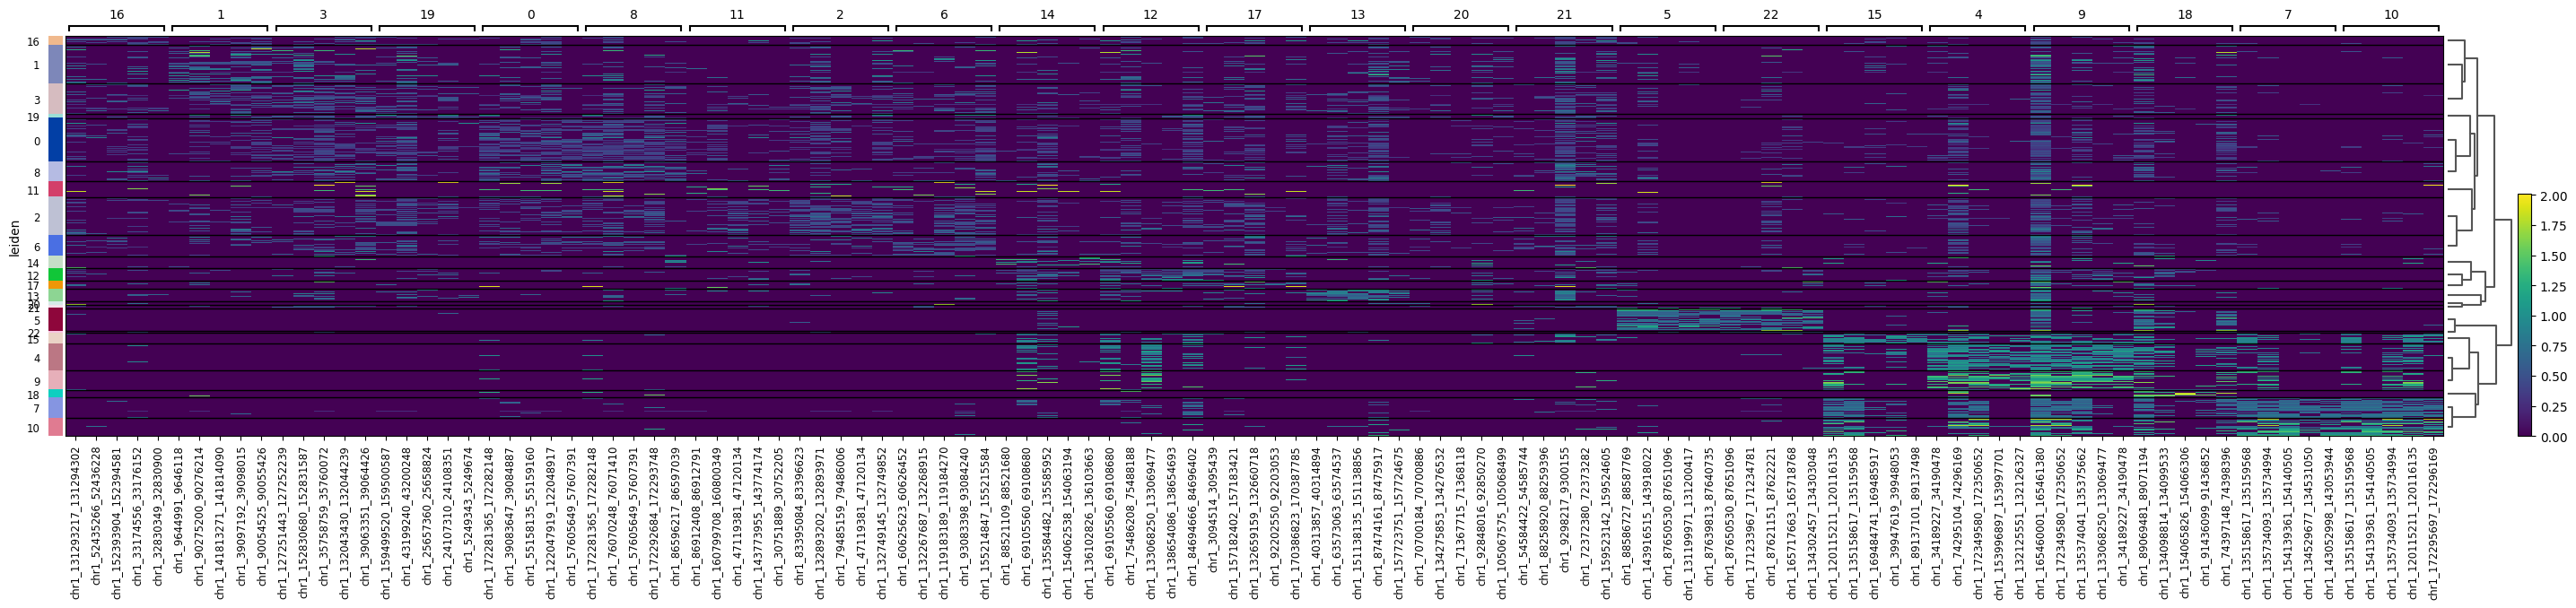

In [42]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, key="wilcoxon", groupby="leiden", show_gene_labels=True)

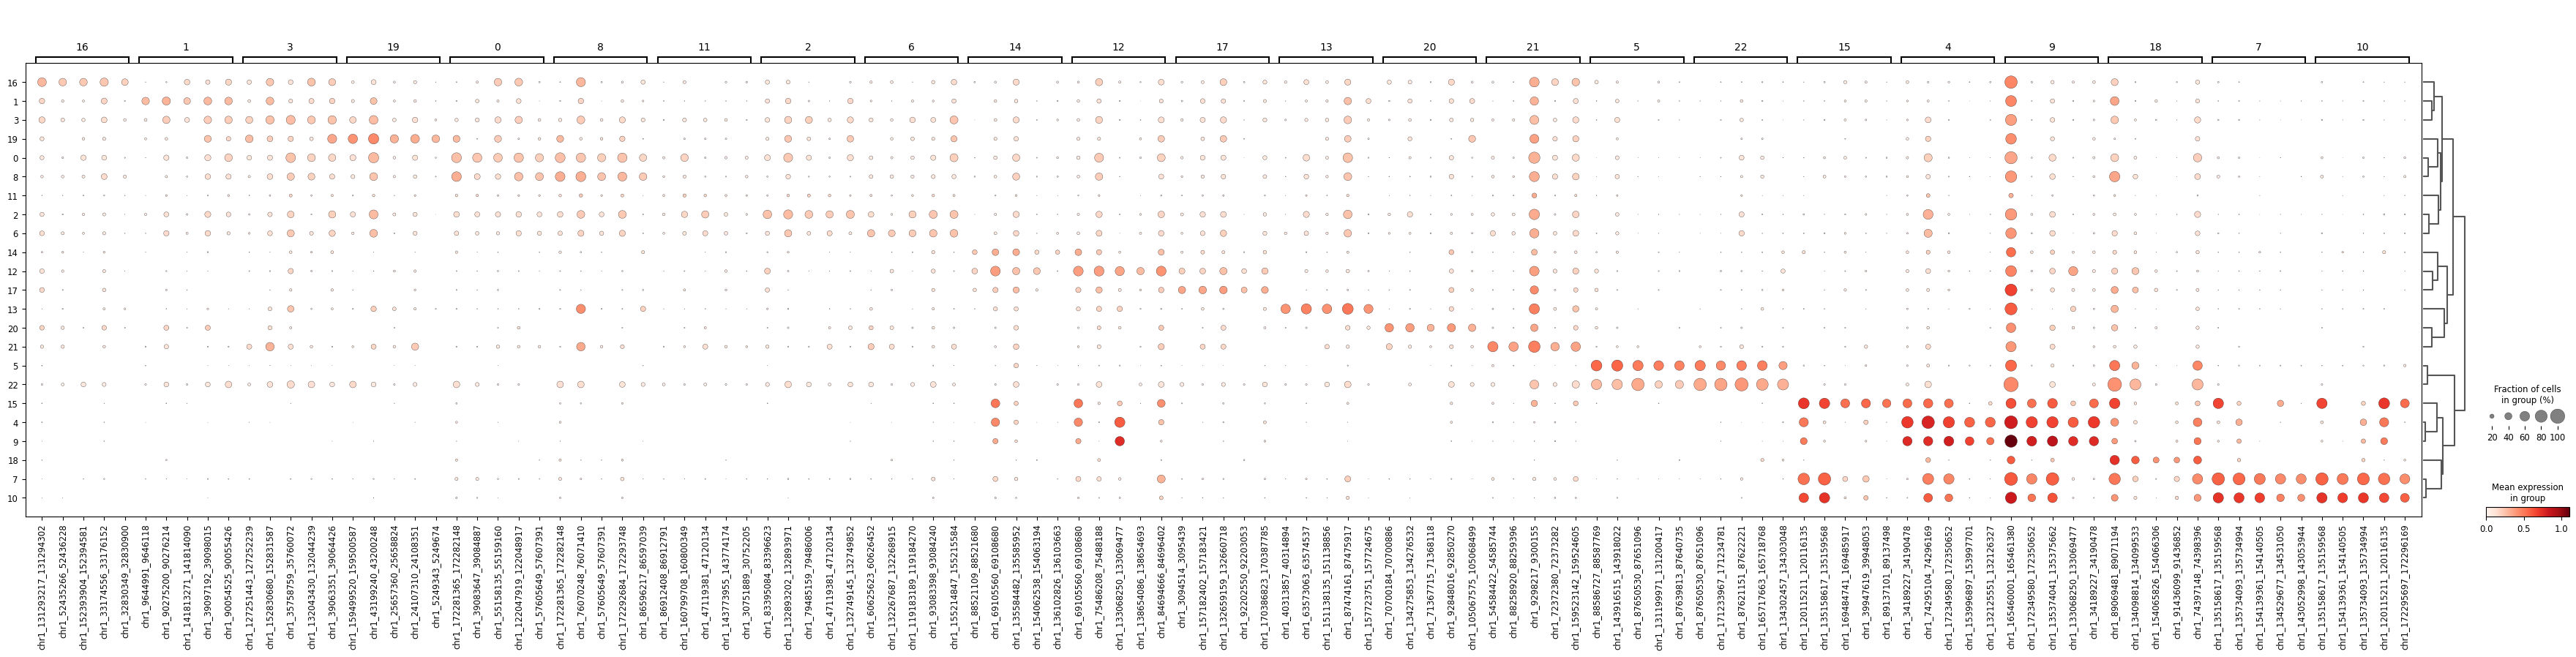

In [43]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, key="wilcoxon", groupby="leiden")

In [41]:
adata.write_h5ad(
    "Normalized.h5ad",
    compression=hdf5plugin.FILTERS["zstd"]
)

In [ ]:
A = adata.layers["scran_normalization"]

pd.DataFrame(A.toarray())

"Evaluation metrics. To evaluate the normalisation results, we determined the root
mean squared error (RMSE) of a robust linear model using the difference between
estimated and simulated library size factors as response variable in rlm() imple-
mented in R-package MASS 49 (v.7.3–51.1) (Supplementary Fig. 10) 9.
All other measures are based on the final results of an entire scRNA-seq
pipeline ending with DE-testing. Knowing the identity of the genes that were
simulated to show differing expression levels and the results of the DE-testing, we
used a number of metrics related to the confusion matrix tabulating the number of
true positives, false positives, true negatives and false negatives. We define the
power to detect DE with the TPR (TPR ¼ TP
TPþFN). The false discovery rate is
defined as FDR ¼ FP
FPþTP . We combine these two measures in a TPR versus FDR
curve to quantify the trade-off between true and false discoveries in a genome-wide
multiple testing setup as advocated by 50. We then summarise these curves by their
partial area under curve (pAUC) of TPR versus observed FDR that still ensures
FDR control at the nominal level of 10% (Supplementary Fig. 11). This way of
calculating the AUC is ideal for data with relatively high true negative rates as the
partial integration does not punish methods that are over-conservative, i.e. that stay
way below the nominal FDR"

"Adding DE then provides us with
detailed performance measures based on how faithfully DE-genes
can be recovered"

"For a detailed evaluation of the pipelines, we simulated two groups of cells for
pairwise comparisons with the following three sample size setups: 96 vs. 96, 384 vs.
384 or 50 vs. 200 cells (Fig. 1b). For simplicity, we kept the number of genes that we
simulated constant at 10,000. To introduce slight variation in expression capture,
we draw a different size factor for each cell from a narrow normal distribution (X ~
N(μ = 1, σ = 0.1)) (Fig. 1b). This distribution fits the considered data sets well,
irrespective of the applied library preparation method. Furthermore, the two
groups of cells can have 5, 20 or 60% differentially expressed genes. To capture the
asymmetry of observed expression differences, we considered three setups of DE-
patterns: symmetric (50% up- and 50% downregulated), asymmetric (75% up- and
25% downregulated) or completely asymmetric (100% upregulated). The
magnitude of expression change is drawn from a narrow gamma distribution (X ~
Γ(α = 1, β = 2)) defining the log2 fold change, which is then added to the sampled
mean expression. The combination of these parameters results in a total of 27 DE-
setups that were then applied to the parameter estimates from 37 different count
matrices to simulate 20 replicates for each setting, producing a total of
19,980 simulated data sets."

https://academic.oup.com/nargab/article/2/3/lqaa059/5893933

"ISnorm correctly estimates true size factors in simulated datasets"